In [1]:
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import sqlite3
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from collections import defaultdict
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

from xgboost import XGBRegressor

In [2]:
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        output = frac_str[:-1]
        
        if output=='+':
            return 0.5
        elif output=='-':
            return -0.5
        
        if output[0]=='-':
            output = float(output) - 0.5
        elif output[0]=='+':
            output = float(output) + 0.5
        return output

In [3]:
def calc_bet_winning_percentages(df):
    spread_wl_1 = []
    spread_wl_2 = []
    spread_wl_4 = []
    for row in df.iterrows():
        row = row[1]
        if row['SPREADS_PRED'] > row['SPREAD_1_AWAY']:
            if row['SPREAD'] > row['SPREAD_1_AWAY']:
                spread_wl_1.append(1)
            elif row['SPREAD'] < row['SPREAD_1_AWAY']:
                spread_wl_1.append(0)
                
        elif row['SPREADS_PRED'] < row['SPREAD_1_AWAY']:
            if row['SPREAD'] < row['SPREAD_1_AWAY']:
                spread_wl_1.append(1)
            elif row['SPREAD'] > row['SPREAD_1_AWAY']:
                spread_wl_1.append(0)
                
        if row['SPREADS_PRED'] > row['SPREAD_2_AWAY']:
            if row['SPREAD'] > row['SPREAD_2_AWAY']:
                spread_wl_2.append(1)
            elif row['SPREAD'] < row['SPREAD_2_AWAY']:
                spread_wl_2.append(0)
                
        elif row['SPREADS_PRED'] < row['SPREAD_2_AWAY']:
            if row['SPREAD'] < row['SPREAD_2_AWAY']:
                spread_wl_2.append(1)
            elif row['SPREAD'] > row['SPREAD_2_AWAY']:
                spread_wl_2.append(0)
                
        if row['SPREADS_PRED'] > row['SPREAD_4_AWAY']:
            if row['SPREAD'] > row['SPREAD_4_AWAY']:
                spread_wl_4.append(1)
            elif row['SPREAD'] < row['SPREAD_4_AWAY']:
                spread_wl_4.append(0)
                
        elif row['SPREADS_PRED'] < row['SPREAD_4_AWAY']:
            if row['SPREAD'] < row['SPREAD_4_AWAY']:
                spread_wl_4.append(1)
            elif row['SPREAD'] > row['SPREAD_4_AWAY']:
                spread_wl_4.append(0)  
                
    spread_1_winning_percentage = sum(spread_wl_1) / len(spread_wl_1)
    spread_2_winning_percentage = sum(spread_wl_2) / len(spread_wl_2)
    spread_4_winning_percentage = sum(spread_wl_4) / len(spread_wl_4)
    
    return spread_1_winning_percentage, spread_2_winning_percentage, spread_4_winning_percentage


In [4]:
def eval_model(model, X_train, y_train, X_test, X_test_game_ids):
    #create df of actual spreads, predicted spreads, and betting spreads
    model = model.fit(X_train, y_train)
    
    predicts_df = pd.DataFrame({'SPREADS_PRED': model.predict(X_test)})
    predicts_df['GAME_ID'] = X_test_game_ids
    
    spread_eval_df = test_spreads_df.merge(predicts_df, how='inner', on='GAME_ID')
    spread_eval_df = spread_eval_df.merge(spreads_df, how='inner', on=['HOME_TEAM','GM_DATE'])
    
    #convert betting spreads to floats
    spread_eval_df['SPREAD_1_AWAY'] = spread_eval_df['SPREAD_1_AWAY'].apply(convert_to_float)
    spread_eval_df['SPREAD_2_AWAY'] = spread_eval_df['SPREAD_2_AWAY'].apply(convert_to_float)
    spread_eval_df['SPREAD_4_AWAY'] = spread_eval_df['SPREAD_4_AWAY'].apply(convert_to_float)
    
    #compute winning percentages for each book
    results1, results2, results4 = calc_bet_winning_percentages(spread_eval_df)
    print('Winning percentage on book 1: ', results1)
    print('Winning percentage on book 2: ', results2)
    print('Winning percentage on book 4: ', results4)

In [52]:
def eval_winnings(model, X_test, X_test_game_ids, confidence_threshold=0, bankroll=1000):
    
    #generate predictions with associated game ids
    predicts_df = pd.DataFrame({'SPREADS_PRED': model.predict(X_test)})
    predicts_df['GAME_ID'] = X_test_game_ids
    
    #create df with predicted spreads, actual spreads, and betting spreads
    winnings_eval_df = test_spreads_df.merge(predicts_df, how='inner', on='GAME_ID')
    winnings_eval_df = winnings_eval_df.merge(spreads_df, how='inner', on=['HOME_TEAM','GM_DATE'])
    
    winnings_eval_df.drop(columns=['SPREAD_1_HOME', 'SPREAD_2_HOME','SPREAD_3_HOME','SPREAD_4_HOME'], inplace=True)
    
    #convert betting spreads to floats
    winnings_eval_df['SPREAD_1_AWAY'] = winnings_eval_df['SPREAD_1_AWAY'].apply(convert_to_float)
    winnings_eval_df['SPREAD_2_AWAY'] = winnings_eval_df['SPREAD_2_AWAY'].apply(convert_to_float)
    winnings_eval_df['SPREAD_3_AWAY'] = winnings_eval_df['SPREAD_3_AWAY'].apply(convert_to_float)
    winnings_eval_df['SPREAD_4_AWAY'] = winnings_eval_df['SPREAD_4_AWAY'].apply(convert_to_float)
    
    #for each game, find betting spread with largest discrepency with predicted spread
    spread_away = np.empty(len(winnings_eval_df))
    odds_away = np.empty(len(winnings_eval_df))
    odds_home = np.empty(len(winnings_eval_df))
    
    for i, row in winnings_eval_df.iterrows():
        
        spread_diff = {}
        
        if not np.isnan(row['SPREAD_1_AWAY']):
            spread_diff['SPREAD_1_AWAY'] = abs(row['SPREAD_1_AWAY'] - row['SPREADS_PRED'])
        if not np.isnan(row['SPREAD_2_AWAY']):
            spread_diff['SPREAD_2_AWAY'] = abs(row['SPREAD_2_AWAY'] - row['SPREADS_PRED'])
        if not np.isnan(row['SPREAD_3_AWAY']):
            spread_diff['SPREAD_3_AWAY'] = abs(row['SPREAD_3_AWAY'] - row['SPREADS_PRED'])
        if not np.isnan(row['SPREAD_4_AWAY']):
            spread_diff['SPREAD_4_AWAY'] = abs(row['SPREAD_4_AWAY'] - row['SPREADS_PRED'])
        
        if not spread_diff:
            continue
            
        book_num = max(spread_diff, key=spread_diff.get)[7]
        
        try:
            spread_away[i] = row['SPREAD_%s_AWAY'%book_num]
            odds_away[i] = row['ODDS_%s_AWAY'%book_num]
            odds_home[i] = row['ODDS_%s_HOME'%book_num]
        except:
            continue
        
    winnings_eval_df.drop(columns=['SPREAD_1_AWAY',
                                   'ODDS_1_AWAY',
                                   'ODDS_1_HOME',
                                   'SPREAD_2_AWAY',
                                   'ODDS_2_AWAY',
                                   'ODDS_2_HOME',
                                   'SPREAD_3_AWAY',
                                   'ODDS_3_AWAY',
                                   'ODDS_3_HOME',
                                   'SPREAD_4_AWAY',
                                   'ODDS_4_AWAY',
                                   'ODDS_4_HOME',], inplace=True)
    
    winnings_eval_df['SPREAD_AWAY'] = spread_away
    winnings_eval_df['ODDS_AWAY'] = odds_away
    winnings_eval_df['ODDS_HOME'] = odds_home
    
    #sort dataframe by date
    winnings_eval_df.sort_values(by='GM_DATE', inplace=True, ignore_index=True)

    #initialize starting bankroll and bet amount
    #bankroll = 1000
    bet_amt = 5
    
    bets_placed = 0
    bankroll_trended = np.empty(len(winnings_eval_df))
    bankroll_trended[0] = bankroll
    wins = np.empty(len(winnings_eval_df))
    
    #compute winnings
    for i, row in winnings_eval_df.iterrows():
        
        winnings=0
        
        if abs(row['SPREADS_PRED'] - row['SPREAD_AWAY']) < confidence_threshold:
            if i==0:
                bankroll_trended[i] = bankroll
            else:
                bankroll_trended[i] = bankroll_trended[i-1]
            continue
        
        if row['SPREADS_PRED'] > row['SPREAD_AWAY']:
            bets_placed += 1
            if row['SPREAD'] < row['SPREAD_AWAY']:
                wins[i] = -1
                winnings = -bet_amt
            elif row['SPREAD'] > row['SPREAD_AWAY']:
                wins[i] = 1
                if row['ODDS_HOME'] < 0:
                    winnings = (100 / abs(row['ODDS_HOME'])) * bet_amt
                elif row['ODDS_HOME'] > 0:
                    winnings = (row['ODDS_HOME'] / 100) * bet_amt
                
        elif row['SPREADS_PRED'] < row['SPREAD_AWAY']:
            bets_placed += 1
            if row['SPREAD'] > row['SPREAD_AWAY']:
                wins[i] = -1
                winnings = -bet_amt
            elif row['SPREAD'] < row['SPREAD_AWAY']:
                wins[i] = 1
                if row['ODDS_AWAY'] < 0:
                    winnings = (100 / abs(row['ODDS_AWAY'])) * bet_amt
                elif row['ODDS_AWAY'] > 0:
                    winnings = (row['ODDS_AWAY'] / 100) * bet_amt
        
        bankroll += winnings
        bankroll_trended[i] = bankroll
    
    win_count = (wins==1).sum()
    loss_count = (wins==-1).sum()
    win_pct = win_count / (win_count+loss_count)
    bankroll_trended_df = pd.DataFrame({'date':winnings_eval_df['GM_DATE'], 'bankroll':bankroll_trended})
    bet_pct = bets_placed / winnings_eval_df.shape[0]
    
    return win_pct, bankroll_trended_df, bet_pct, winnings_eval_df, wins
    #return win_pct, bankroll_trended_df

In [6]:
def get_data(test_season):
    
    #import boxscore data
    df = pd.read_csv('data_v2_0.05.csv')
    df = df[df['SEASON'] <= test_season]
    df.drop(columns=['Unnamed: 0'], inplace=True)
    df.rename(columns={'HOME_TEAM_ID':'TEAM_ID_HOME', 'HOME_TEAM_CITY':'TEAM_CITY_HOME'}, inplace=True)
    
    #create test_spreads_df for model evaluation later
    test_df = df[df['SEASON'] == test_season].copy()
    test_spreads_df = test_df[['GAME_ID','GAME_DATE','TEAM_ID_HOME','TEAM_CITY_HOME','SPREAD']].copy()
    test_spreads_df['TEAM_CITY_HOME'] = test_spreads_df['TEAM_CITY_HOME'].map({'LA':'L.A. Clippers', 
                                                                               'Los Angeles':'L.A. Lakers',
                                                                               'Boston': 'Boston',
                                                                               'Golden State': 'Golden State',
                                                                               'Miami': 'Miami',
                                                                               'Dallas':'Dallas',
                                                                               'Phoenix':'Phoenix',
                                                                               'Milwaukee':'Milwaukee',
                                                                               'Philadelphia':'Philadelphia',
                                                                               'Memphis':'Memphis',
                                                                               'Minnesota':'Minnesota',
                                                                               'Utah':'Utah',
                                                                               'New Orleans':'New Orleans',
                                                                               'Toronto':'Toronto',
                                                                               'Brooklyn':'Brooklyn',
                                                                               'Atlanta':'Atlanta',
                                                                               'Denver':'Denver',
                                                                               'Chicago':'Chicago',
                                                                               'Houston':'Houston',
                                                                               'Portland':'Portland',
                                                                               'Cleveland':'Cleveland',
                                                                               'Charlotte':'Charlotte',
                                                                               'Orlando':'Orlando',
                                                                               'New York':'New York',
                                                                               'San Antonio':'San Antonio',
                                                                               'Washington':'Washington',
                                                                               'Detroit':'Detroit',
                                                                               'Sacramento':'Sacramento',
                                                                               'Oklahoma City':'Oklahoma City',
                                                                               'Indiana':'Indiana'
                                                                              })
    test_spreads_df.rename(columns={'TEAM_CITY_HOME':'HOME_TEAM', 'GAME_DATE':'GM_DATE'}, inplace=True)
    
    #Standardize boxscore data
    df.drop(columns=['TEAM_ID_HOME',
                     'GAME_DATE',
                     'TEAM_CITY_HOME',
                     'SEASON'], inplace=True)

    non_feature_cols = {'GAME_ID', 'SPREAD'}
    feature_cols = set(df.columns) - non_feature_cols

    sclr = StandardScaler()
    df[list(feature_cols)] = sclr.fit_transform(df[list(feature_cols)])
    
    #apply dimensionality reduction to data, keeping n components
    n_components = 20
    pca=PCA(n_components=n_components)
    
    df_ids_spreads = df[list(non_feature_cols)].copy()
    #print(df_ids_spreads)

    df_pca = pd.DataFrame(pca.fit_transform(df[list(feature_cols)]))
    df_pca['GAME_ID'] = np.array(df_ids_spreads['GAME_ID'])
    df_pca['SPREAD'] = np.array(df_ids_spreads['SPREAD'])
    #print(df_pca)
    
    #split pca data into train and test
    test_ids_set = set(test_spreads_df['GAME_ID'])

    train_pca = df_pca[~df_pca['GAME_ID'].isin(test_ids_set)].copy()
    test_pca = df_pca[df_pca['GAME_ID'].isin(test_ids_set)].copy()

    train_game_ids = train_pca['GAME_ID'].copy()
    test_game_ids = test_pca['GAME_ID'].copy()

    y_train_pca = train_pca['SPREAD']
    X_train_pca = train_pca.drop(columns=['SPREAD','GAME_ID'])
    
    #print(y_train_pca)

    y_test_pca = test_pca['SPREAD']
    X_test_pca = test_pca.drop(columns=['SPREAD','GAME_ID'])
    
    return X_train_pca, y_train_pca, X_test_pca, y_test_pca, test_game_ids, test_spreads_df
    

In [7]:
df = pd.read_csv('data_elo.csv')
df.rename(columns={'HOME_TEAM_ID':'TEAM_ID_HOME', 'HOME_TEAM_CITY':'TEAM_CITY_HOME'}, inplace=True)
df.columns

Index(['Unnamed: 0', 'TS_PCT', 'PIE', 'REB_PCT', 'PF', 'STL', 'E_PACE', 'WL',
       'FG3M', 'TM_TOV_PCT', 'DEF_RATING', 'BLK', 'REB', 'AST_TOV', 'ELO',
       'E_OFF_RATING', 'FGA', 'EFG_PCT', 'OREB', 'TOV', 'E_TM_TOV_PCT',
       'E_USG_PCT', 'FG3A', 'FTM', 'OREB_PCT', 'FT_PCT', 'FG3_PCT',
       'PACE_PER40', 'DREB', 'PLUS_MINUS', 'E_NET_RATING', 'AST', 'POSS',
       'E_DEF_RATING', 'FGM', 'FG_PCT', 'PACE', 'OFF_RATING', 'FTA', 'PTS',
       'MIN', 'AST_RATIO', 'USG_PCT', 'DREB_PCT', 'AST_PCT', 'NET_RATING',
       'SEASON', 'GAME_DATE', 'GAME_ID', 'TEAM_ID_HOME', 'TEAM_CITY_HOME',
       'SPREAD'],
      dtype='object')

In [8]:
#import betting spreads data
spreads_df = pd.read_csv('spreads_df.csv')
spreads_df.drop(columns=['Unnamed: 0'], inplace=True)

In [80]:
#evaluate 2017-18 season
X_train, y_train, X_test, y_test, test_game_ids, test_spreads_df = get_data('2017-18')

lin_reg = LinearRegression()

lin_reg_CV_score = cross_val_score(lin_reg, X_train, y_train, cv=5)
print('Linear regression CV scores: ', lin_reg_CV_score)
print('Linear regression avg. CV score: ', lin_reg_CV_score.mean())

lin_reg.fit(X_train, y_train)

win_pct, bankroll_trended_df, eval_df, wins = eval_winnings(lin_reg, X_test, test_game_ids, confidence_threshold=7)
print('Test set win percentage: ', win_pct)

plt.plot(bankroll_trended_df['date'], bankroll_trended_df['bankroll'])

bankroll_18 = bankroll_trended_df['bankroll'].iloc[-1]
print('Bankroll at end of 2017-18 season: ', bankroll_18)

Linear regression CV scores:  [0.14135839 0.11943163 0.18893904 0.17599627 0.16841345]
Linear regression avg. CV score:  0.15882775686815387


IndexError: index 0 is out of bounds for axis 0 with size 0

Linear regression CV scores:  [0.15560416 0.16932787 0.19239299 0.13242598 0.13514791]
Linear regression avg. CV score:  0.1569797812422833
Test set win percentage:  0.4166666666666667
Bankroll at end of 2018-19 season:  981.0030207670013


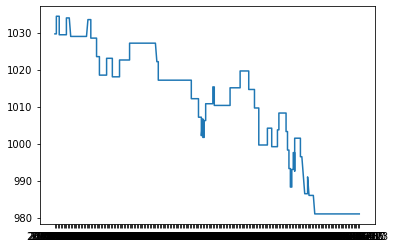

In [42]:
#evaluate 2018-19 season
X_train, y_train, X_test, y_test, test_game_ids, test_spreads_df = get_data('2018-19')

lin_reg = LinearRegression()

lin_reg_CV_score = cross_val_score(lin_reg, X_train, y_train, cv=5)
print('Linear regression CV scores: ', lin_reg_CV_score)
print('Linear regression avg. CV score: ', lin_reg_CV_score.mean())

lin_reg.fit(X_train, y_train)

win_pct, bankroll_trended_df, eval_df, wins = eval_winnings(lin_reg, X_test, test_game_ids, confidence_threshold=7, bankroll=bankroll_18)
print('Test set win percentage: ', win_pct)

plt.plot(bankroll_trended_df['date'], bankroll_trended_df['bankroll'])

bankroll_19 = bankroll_trended_df['bankroll'].iloc[-1]
print('Bankroll at end of 2018-19 season: ', bankroll_19)

Linear regression CV scores:  [0.15030179 0.17360214 0.17495548 0.15115562 0.13642497]
Linear regression avg. CV score:  0.157288001346293
Test set win percentage:  0.4430379746835443
Bankroll at end of 2019-20 season:  919.1222566036271


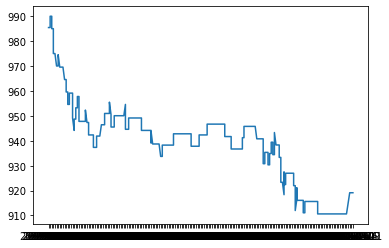

In [43]:
#evaluate 2019-20 season
X_train, y_train, X_test, y_test, test_game_ids, test_spreads_df = get_data('2019-20')

lin_reg = LinearRegression()

lin_reg_CV_score = cross_val_score(lin_reg, X_train, y_train, cv=5)
print('Linear regression CV scores: ', lin_reg_CV_score)
print('Linear regression avg. CV score: ', lin_reg_CV_score.mean())

lin_reg.fit(X_train, y_train)

win_pct, bankroll_trended_df, eval_df, wins = eval_winnings(lin_reg, X_test, test_game_ids, confidence_threshold=7, bankroll=bankroll_19)
print('Test set win percentage: ', win_pct)

plt.plot(bankroll_trended_df['date'], bankroll_trended_df['bankroll'])

bankroll_20 = bankroll_trended_df['bankroll'].iloc[-1]
print('Bankroll at end of 2019-20 season: ', bankroll_20)

In [81]:
#evaluate 2020-21 season
X_train, y_train, X_test, y_test, test_game_ids, test_spreads_df = get_data('2020-21')

lin_reg = LinearRegression()

lin_reg_CV_score = cross_val_score(lin_reg, X_train, y_train, cv=5)
print('Linear regression CV scores: ', lin_reg_CV_score)
print('Linear regression avg. CV score: ', lin_reg_CV_score.mean())

lin_reg.fit(X_train, y_train)

win_pct, bankroll_trended_df, eval_df, wins = eval_winnings(lin_reg, X_test, test_game_ids, confidence_threshold=7, bankroll=1000)
print('Test set win percentage: ', win_pct)

plt.plot(bankroll_trended_df['date'], bankroll_trended_df['bankroll'])

bankroll_21 = bankroll_trended_df['bankroll'].iloc[-1]
print('Bankroll at end of 2020-21 season: ', bankroll_21)

Linear regression CV scores:  [0.13683088 0.15463117 0.17367508 0.18201561 0.14288815]
Linear regression avg. CV score:  0.15800817818139734


IndexError: index 0 is out of bounds for axis 0 with size 0

In [79]:
#evaluate 2021-22 season
X_train, y_train, X_test, y_test, test_game_ids, test_spreads_df = get_data('2021-22')

lin_reg = LinearRegression()

lin_reg_CV_score = cross_val_score(lin_reg, X_train, y_train, cv=5)
print('Linear regression CV scores: ', lin_reg_CV_score)
print('Linear regression avg. CV score: ', lin_reg_CV_score.mean())

lin_reg.fit(X_train, y_train)

win_pct, bankroll_trended_df, eval_df, wins = eval_winnings(lin_reg, X_test, test_game_ids, confidence_threshold=7, bankroll=bankroll_21)
print('Test set win percentage: ', win_pct)

plt.plot(bankroll_trended_df['date'], bankroll_trended_df['bankroll'])

bankroll_22 = bankroll_trended_df['bankroll'].iloc[-1]
print('Bankroll at end of 2021-22 season: ', bankroll_22)

Linear regression CV scores:  [0.13699559 0.15511083 0.17409725 0.17272898 0.13889851]
Linear regression avg. CV score:  0.15556623231747552


NameError: name 'bankroll_21' is not defined

In [9]:
#create test set and create test_spreads_df for model evaluation
test_seasons = ['2021-22', '2020-21', '2019-20', '2018-19', '2017-18']

test_df = df[df['SEASON'].isin(test_seasons)].copy()
test_spreads_df = test_df[['GAME_ID','GAME_DATE','TEAM_ID_HOME','TEAM_CITY_HOME','SPREAD']].copy()
test_spreads_df['TEAM_CITY_HOME'] = test_spreads_df['TEAM_CITY_HOME'].map({'LA':'L.A. Clippers', 
                                                                           'Los Angeles':'L.A. Lakers',
                                                                           'Boston': 'Boston',
                                                                           'Golden State': 'Golden State',
                                                                           'Miami': 'Miami',
                                                                           'Dallas':'Dallas',
                                                                           'Phoenix':'Phoenix',
                                                                           'Milwaukee':'Milwaukee',
                                                                           'Philadelphia':'Philadelphia',
                                                                           'Memphis':'Memphis',
                                                                           'Minnesota':'Minnesota',
                                                                           'Utah':'Utah',
                                                                           'New Orleans':'New Orleans',
                                                                           'Toronto':'Toronto',
                                                                           'Brooklyn':'Brooklyn',
                                                                           'Atlanta':'Atlanta',
                                                                           'Denver':'Denver',
                                                                           'Chicago':'Chicago',
                                                                           'Houston':'Houston',
                                                                           'Portland':'Portland',
                                                                           'Cleveland':'Cleveland',
                                                                           'Charlotte':'Charlotte',
                                                                           'Orlando':'Orlando',
                                                                           'New York':'New York',
                                                                           'San Antonio':'San Antonio',
                                                                           'Washington':'Washington',
                                                                           'Detroit':'Detroit',
                                                                           'Sacramento':'Sacramento',
                                                                           'Oklahoma City':'Oklahoma City',
                                                                           'Indiana':'Indiana'
                                                                          })
test_spreads_df.rename(columns={'TEAM_CITY_HOME':'HOME_TEAM', 'GAME_DATE':'GM_DATE'}, inplace=True)
test_spreads_df.head()

,GAME_ID,GM_DATE,TEAM_ID_HOME,HOME_TEAM,SPREAD
21117,21700001,2017-10-17,1610612739,Cleveland,3.0
21118,21700002,2017-10-17,1610612744,Golden State,-1.0
21119,21700003,2017-10-18,1610612765,Detroit,12.0
21120,21700004,2017-10-18,1610612754,Indiana,9.0
21121,21700005,2017-10-18,1610612753,Orlando,7.0


In [10]:
#create training dataset
train_df = df[df['SEASON'].isin(test_seasons)==False].copy()

In [11]:
#drop unnecessary columns
test_df.drop(columns=['Unnamed: 0',
                 'TEAM_ID_HOME',
                 'GAME_ID',
                 'GAME_DATE',
                 'TEAM_CITY_HOME'], inplace=True)
train_df.drop(columns=['Unnamed: 0',
                 'TEAM_ID_HOME',
                 'GAME_ID',
                 'GAME_DATE',
                 'TEAM_CITY_HOME'], inplace=True)

In [12]:
#separate spread actuals from training and testing data
X_train = train_df.drop(columns=['SPREAD','SEASON'])
y_train = train_df['SPREAD']
X_test = test_df.drop(columns=['SPREAD', 'SEASON'])
y_test = test_df['SPREAD']

In [13]:
X_train.head()

,TS_PCT,PIE,REB_PCT,PF,STL,E_PACE,WL,FG3M,TM_TOV_PCT,DEF_RATING,...,PACE,OFF_RATING,FTA,PTS,MIN,AST_RATIO,USG_PCT,DREB_PCT,AST_PCT,NET_RATING
0,0.023167,0.083206,-0.013398,-0.062541,1.576017,-2.449737,0.323626,1.993233,-2.180408,-7.013257,...,-1.651514,1.586411,1.708658,0.295988,0.688165,0.937767,0.0,0.026079,0.054947,8.604764
1,0.005937,0.011904,0.025478,-2.884594,0.294281,-2.964517,-0.005804,0.517092,2.217534,-1.741171,...,-2.460772,-1.035638,2.602118,-3.352608,-0.406002,-1.342768,0.0,0.014510,-0.028727,0.704474
2,0.001986,0.020987,0.034987,-1.362331,-1.308543,2.520978,0.042348,0.248448,1.536961,-1.001472,...,2.312433,0.606956,0.091193,2.844252,0.422211,-0.346880,0.0,0.029505,-0.028361,1.606810
3,-0.007023,-0.025634,0.027347,0.040522,-0.674190,3.718695,-0.091721,-0.949803,-1.320912,7.417952,...,3.472180,5.131948,0.843280,7.858159,-0.678399,2.037575,0.0,0.009259,0.052569,-2.284216
4,0.015543,0.011998,0.017881,-2.908055,-1.648527,-0.267758,0.076961,-1.036224,0.471922,3.199901,...,-0.196528,4.245733,0.517570,3.268755,-0.848107,0.322562,0.0,-0.016127,-0.018852,1.036185


In [14]:
#Create standardized dataset
df.drop(columns=['Unnamed: 0',
                 'TEAM_ID_HOME',
                 'GAME_DATE',
                 'TEAM_CITY_HOME',
                 'SEASON'], inplace=True)

non_feature_cols = {'GAME_ID', 'SPREAD'}
feature_cols = set(df.columns) - non_feature_cols

#standardize features
sclr = StandardScaler()
df[list(feature_cols)] = sclr.fit_transform(df[list(feature_cols)])
df.head()

,TS_PCT,PIE,REB_PCT,PF,STL,E_PACE,WL,FG3M,TM_TOV_PCT,DEF_RATING,...,FTA,PTS,MIN,AST_RATIO,USG_PCT,DREB_PCT,AST_PCT,NET_RATING,GAME_ID,SPREAD
0,0.904705,1.771392,-0.612333,-0.035506,1.248058,-0.722813,1.512252,0.914586,-1.315327,-1.584155,...,0.504545,0.057281,0.396771,0.572749,0.0,1.049594,0.976413,1.293706,20000711,2.0
1,0.234097,0.262967,1.202120,-1.412543,0.232471,-0.875392,-0.017038,0.235970,1.332182,-0.399166,...,0.766805,-0.546470,-0.230206,-0.801659,0.0,0.586783,-0.502168,0.115668,20000721,21.0
2,0.080330,0.455128,1.645953,-0.669746,-1.037531,0.750482,0.206496,0.112468,0.922484,-0.232907,...,0.029766,0.478955,0.244375,-0.201468,0.0,1.186684,-0.495708,0.250218,20000726,19.0
3,-0.270293,-0.531170,1.289351,0.014785,-0.534899,1.105480,-0.415888,-0.438396,-0.797921,1.659499,...,0.250529,1.308630,-0.386294,1.235569,0.0,0.376730,0.934395,-0.329985,20000729,-7.0
4,0.607966,0.264955,0.847531,-1.423991,-1.306919,-0.076085,0.367178,-0.478126,0.281344,0.711422,...,0.154922,0.549199,-0.483540,0.201983,0.0,-0.638843,-0.327679,0.165131,20000734,-20.0


Text(0, 0.5, 'cumulative explained variance')

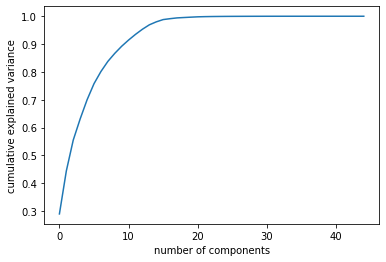

In [15]:
#PCA to minimize multicollinearity
pca = PCA().fit(df[list(feature_cols)])

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

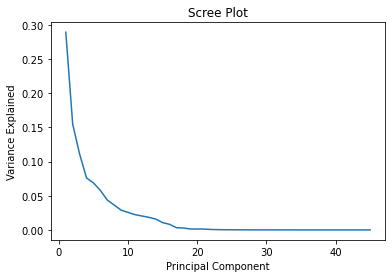

In [16]:
principal_components = np.arange(pca.n_components_)+1
plt.plot(principal_components, pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [17]:
#apply dimensionality reduction to data, keeping n components
n_components = 20
pca=PCA(n_components=n_components)

df_ids_spreads = df[list(non_feature_cols)].copy()

df_pca = pd.DataFrame(pca.fit_transform(df[list(feature_cols)]))
df_pca['GAME_ID'] = df_ids_spreads['GAME_ID']
df_pca['SPREAD'] = df_ids_spreads['SPREAD']
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,GAME_ID,SPREAD
0,-4.191760,-2.608205,1.864478,0.694952,-0.526055,-1.879243,-3.027443,1.164236,-2.581055,0.486824,...,-2.295215,-1.052224,-0.897407,-0.223550,-0.162493,-0.179098,-0.087740,0.307438,20000711,2.0
1,0.920130,-2.146417,-2.458590,1.155902,-1.752429,-0.439910,1.115492,-0.658455,-0.414046,-1.107559,...,-0.301659,-1.536464,-0.904981,0.126223,0.038269,-0.194324,0.244327,-0.063213,20000721,21.0
2,-1.169598,1.460384,-3.122518,-0.731019,0.847428,-0.322921,2.664228,0.339560,0.568556,-0.661272,...,-1.839692,-0.356999,-0.870789,0.032722,-0.583721,-0.005373,0.016921,-0.060991,20000726,19.0
3,-1.349342,3.833427,-0.252943,-3.153443,1.881603,3.830571,1.911361,0.052289,-0.665210,-0.219027,...,0.625347,0.999099,-0.472899,1.071523,-0.027326,0.172346,-0.087367,-0.139240,20000729,-7.0
4,-1.633227,0.285636,-0.704053,-0.547860,-0.779714,1.704825,2.296978,0.533048,1.159765,-0.956665,...,-0.124854,-0.561451,-1.021661,-0.839614,0.257138,0.359876,-0.039135,-0.186703,20000734,-20.0


In [18]:
#split pca data into train and test
test_ids_set = set(test_spreads_df['GAME_ID'])

train_pca = df_pca[~df_pca['GAME_ID'].isin(test_ids_set)].copy()
test_pca = df_pca[df_pca['GAME_ID'].isin(test_ids_set)].copy()

train_game_ids = train_pca['GAME_ID'].copy()
test_game_ids = test_pca['GAME_ID'].copy()

y_train_pca = train_pca['SPREAD']
X_train_pca = train_pca.drop(columns=['SPREAD','GAME_ID'])

y_test_pca = test_pca['SPREAD']
X_test_pca = test_pca.drop(columns=['SPREAD','GAME_ID'])

X_train_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-4.191760,-2.608205,1.864478,0.694952,-0.526055,-1.879243,-3.027443,1.164236,-2.581055,0.486824,-2.129565,-0.244205,-2.295215,-1.052224,-0.897407,-0.223550,-0.162493,-0.179098,-0.087740,0.307438
1,0.920130,-2.146417,-2.458590,1.155902,-1.752429,-0.439910,1.115492,-0.658455,-0.414046,-1.107559,0.249378,-0.821571,-0.301659,-1.536464,-0.904981,0.126223,0.038269,-0.194324,0.244327,-0.063213
2,-1.169598,1.460384,-3.122518,-0.731019,0.847428,-0.322921,2.664228,0.339560,0.568556,-0.661272,0.403651,-0.248648,-1.839692,-0.356999,-0.870789,0.032722,-0.583721,-0.005373,0.016921,-0.060991
3,-1.349342,3.833427,-0.252943,-3.153443,1.881603,3.830571,1.911361,0.052289,-0.665210,-0.219027,1.271762,0.575203,0.625347,0.999099,-0.472899,1.071523,-0.027326,0.172346,-0.087367,-0.139240
4,-1.633227,0.285636,-0.704053,-0.547860,-0.779714,1.704825,2.296978,0.533048,1.159765,-0.956665,1.130386,0.272306,-0.124854,-0.561451,-1.021661,-0.839614,0.257138,0.359876,-0.039135,-0.186703


In [53]:
#linear regression
lin_reg = LinearRegression()

lin_reg_CV_score = cross_val_score(lin_reg, X_train_pca, y_train_pca, cv=5)
print('Linear regression CV scores: ', lin_reg_CV_score)
print('Linear regression avg. CV score: ', lin_reg_CV_score.mean())

lin_reg.fit(X_train_pca, y_train_pca)

lin_reg_win_pct, lin_reg_bankroll_trended_df, bet_pct, eval_df, wins = eval_winnings(lin_reg, X_test_pca, test_ids_set, confidence_threshold=20)
print('Test set win percentage: ', lin_reg_win_pct)
print('Final bankroll: ', lin_reg_bankroll_trended_df.iloc[-1]['bankroll'])
print('Percent of bets placed: ', bet_pct)

Linear regression CV scores:  [0.15303471 0.12428905 0.19336659 0.18461079 0.17456226]
Linear regression avg. CV score:  0.16597268038865404
Test set win percentage:  0.6164383561643836
Final bankroll:  1063.6263527117724
Percent of bets placed:  0.011872292635969837


In [30]:
lin_reg_bankroll_trended_df.head()

,date,bankroll
0,2017-10-17,1000.0
1,2017-10-17,1000.0
2,2017-10-18,1000.0
3,2017-10-18,1000.0
4,2017-10-18,1000.0


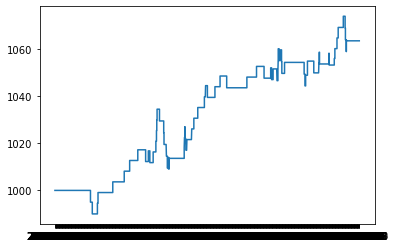

In [31]:
plt.plot(lin_reg_bankroll_trended_df['date'], lin_reg_bankroll_trended_df['bankroll'])

In [32]:
lin_reg_bankroll_trended_df['bankroll'].iloc[-1]

1063.6263527117724

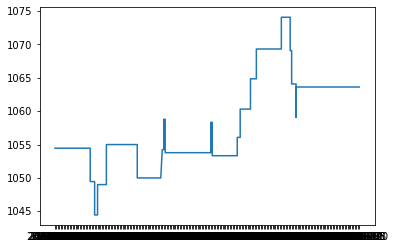

In [33]:
season_21_22 = lin_reg_bankroll_trended_df[lin_reg_bankroll_trended_df['date'] > '2021-10-01']
plt.plot(season_21_22['date'], season_21_22['bankroll'])

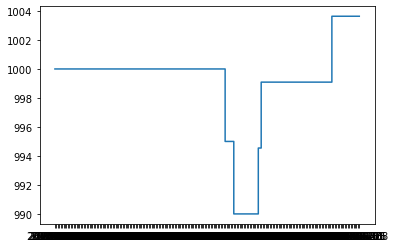

In [34]:
season_17_18 = lin_reg_bankroll_trended_df[lin_reg_bankroll_trended_df['date'] < '2018-08-01']
plt.plot(season_17_18['date'], season_17_18['bankroll'])

In [22]:
#examine performance of 2017-18 regular season
'''
bankroll_17_18 = lin_reg_bankroll_trended_df[lin_reg_bankroll_trended_df['date'] < '2018-04-01']
print(bankroll_17_18['bankroll'].iloc[-1])
plt.plot(bankroll_17_18['date'], bankroll_17_18['bankroll'])
'''

"\nbankroll_17_18 = lin_reg_bankroll_trended_df[lin_reg_bankroll_trended_df['date'] < '2018-04-01']\nprint(bankroll_17_18['bankroll'].iloc[-1])\nplt.plot(bankroll_17_18['date'], bankroll_17_18['bankroll'])\n"

(array([1.890e+03, 1.633e+03, 1.201e+03, 7.290e+02, 3.350e+02, 1.310e+02,
        3.900e+01, 8.000e+00, 2.000e+00, 1.000e+00]),
 array([2.58459621e-03, 3.56076165e+00, 7.11893870e+00, 1.06771158e+01,
        1.42352928e+01, 1.77934699e+01, 2.13516469e+01, 2.49098240e+01,
        2.84680010e+01, 3.20261781e+01, 3.55843551e+01]),
 <BarContainer object of 10 artists>)

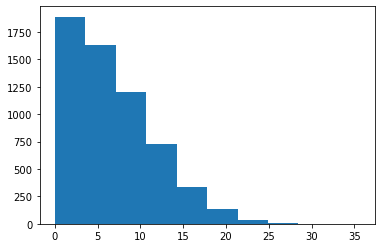

In [35]:
#SCRATCH CELL
eval_df['WINS'] = wins
eval_df['SPREAD_DIFF'] = abs(eval_df['SPREAD_AWAY'] - eval_df['SPREADS_PRED'])
plt.hist(eval_df['SPREAD_DIFF'])
#eval_df.head()

In [36]:
eval_df['SPREAD_DIFF_UNDER_2'] = eval_df['SPREAD_DIFF'] < 2
eval_df['SPREAD_DIFF_2_5'] = (eval_df['SPREAD_DIFF'] >= 2) & (eval_df['SPREAD_DIFF'] < 5) 
eval_df['SPREAD_DIFF_5_10'] = (eval_df['SPREAD_DIFF'] >= 5) & (eval_df['SPREAD_DIFF'] < 10) 
eval_df['SPREAD_DIFF_OVER_10'] = (eval_df['SPREAD_DIFF'] >= 20)


In [37]:
wins

array([0.0000e+000, 4.9407e-324, 5.9288e-323, ..., 3.0780e-320,
       3.0785e-320, 3.0790e-320])

In [39]:
diff_under_2_df = eval_df[eval_df['SPREAD_DIFF_UNDER_2']] 
#print(sum(diff_under_2_df['WINS']==1) / (sum(diff_under_2_df['WINS']==1) + sum(diff_under_2_df['WINS']==-1)))

diff_2_5_df = eval_df[eval_df['SPREAD_DIFF_2_5']] 
#print(sum(diff_2_5_df['WINS']==1) / (sum(diff_2_5_df['WINS']==1) + sum(diff_2_5_df['WINS']==-1)))

diff_5_10_df = eval_df[eval_df['SPREAD_DIFF_5_10']] 
#print(sum(diff_5_10_df['WINS']==1) / (sum(diff_5_10_df['WINS']==1) + sum(diff_5_10_df['WINS']==-1)))

diff_over_10_df = eval_df[eval_df['SPREAD_DIFF_OVER_10']] 
print(sum(diff_over_10_df['WINS']==1) / (sum(diff_over_10_df['WINS']==1) + sum(diff_over_10_df['WINS']==-1)))



0.6164383561643836


In [45]:
#Test different confidence thresholds
threshold = 10

threshold_test_df = eval_df[eval_df['SPREAD_DIFF'] >= threshold] 
win_pct = sum(threshold_test_df['WINS']==1) / (sum(threshold_test_df['WINS']==1) + sum(threshold_test_df['WINS']==-1))

print('Win percentage: ', win_pct)

bet_pct = len(threshold_test_df) / len(eval_df[eval_df['WINS']!=0])
print('Percentage of total possible bets placed: ', bet_pct)

Win percentage:  0.6164383561643836
Percentage of total possible bets placed:  0.23250962772785622


In [49]:
#polynomial regression
confidence_thresh = 20
degree = 2
poly=PolynomialFeatures(degree)
X_train_poly = poly.fit_transform(X_train_pca)
X_test_poly = poly.fit_transform(X_test_pca)
poly_reg = LinearRegression()

poly_reg_CV_score = cross_val_score(poly_reg, X_train_poly, y_train_pca, cv=5)
print('Polynomial regression CV scores: ', poly_reg_CV_score)
print('Polynomial regression avg. CV score: ', poly_reg_CV_score.mean())

poly_reg.fit(X_train_poly, y_train_pca)

poly_reg_win_pct, poly_reg_bankroll_trended_df = eval_winnings(poly_reg, X_test_poly, test_ids_set, confidence_threshold=confidence_thresh)[:3]
print('Test set win percentage: ', poly_reg_win_pct)
print('Final bankroll: ', poly_reg_bankroll_trended_df.iloc[-1]['bankroll'])
print('Percent of bets placed: ', bet_pct)

Polynomial regression CV scores:  [0.13879711 0.11176979 0.187331   0.16480098 0.16483371]
Polynomial regression avg. CV score:  0.15350651680152308
Test set win percentage:  0.6067415730337079
Final bankroll:  1068.561417646837


In [87]:
#Random Forrest implementation
#Baseline RF CV results

rf = RandomForestRegressor()
rf_score = cross_val_score(rf, X_train_pca, y_train_pca, cv=5)
print('Random forest CV scores: ', rf_score)
print('Random forest avg. CV score: ', rf_score.mean())

rf.fit(X_train_pca, y_train_pca)
rf_win_pct, rf_bankroll_trended_df = eval_winnings(rf, X_test_pca, test_ids_set)[:2]
print('Test set win percentage: ', rf_win_pct)
print('Final bankroll: ', rf_bankroll_trended_df.iloc[-1]['bankroll'])

Random forest CV scores:  [0.12267613 0.09747307 0.17399289 0.15692126 0.14957155]
Random forest avg. CV score:  0.14012698085022932
Test set win percentage:  0.5173764906303236
Final bankroll:  60.10315592230427


In [88]:
#xgboost
xgb = XGBRegressor()

xgb_score = cross_val_score(xgb, X_train_pca, y_train_pca, cv=5)
print('XGBoost CV scores: ', xgb_score)
print('XGBoost avg. CV score: ', xgb_score.mean())

xgb.fit(X_train_pca, y_train_pca)

xgb_win_pct, xgb_bankroll_trended_df = eval_winnings(xgb, X_test_pca, test_ids_set)[:2]
print('Test set win percentage: ', xgb_win_pct)
print('Final bankroll: ', xgb_bankroll_trended_df.iloc[-1]['bankroll'])

XGBoost CV scores:  [0.06278955 0.03140086 0.13594453 0.11312777 0.09409193]
XGBoost avg. CV score:  0.08747092846974809
Test set win percentage:  0.5114932743061468
Final bankroll:  -236.3907575619323


In [89]:
#KNN
knn = KNeighborsRegressor()

knn_score = cross_val_score(knn, X_train_pca, y_train_pca, cv=5)
print('KNN CV scores: ', knn_score)
print('KNN avg. CV score: ', knn_score.mean())

knn.fit(X_train_pca, y_train_pca)

knn_win_pct, knn_bankroll_trended_df = eval_winnings(knn, X_test_pca, test_ids_set)[:2]
print('Test set win percentage: ', knn_win_pct)
print('Final bankroll: ', knn_bankroll_trended_df.iloc[-1]['bankroll'])

KNN CV scores:  [-0.04004796 -0.05981631  0.01826444  0.00775536  0.01919527]
KNN avg. CV score:  -0.010929839720024436
Test set win percentage:  0.5162337662337663
Final bankroll:  46.004147723307696


In [ ]:
#DELETE CELL
#evaluate baseline polynomical regression model
poly_reg = LinearRegression()
eval_model(poly_reg, X_train_poly, y_train_pca, X_test_poly, test_game_ids)

In [ ]:
#score on training and test data to check for overfitting
training_score = poly_reg.score(X_train_poly, y_train_pca)
test_score = poly_reg.score(X_test_poly, y_test_pca)

print('Training score: ', training_score)
print('Test score: ', test_score)

In [ ]:
plt.plot(bankroll_trended_df['date'], bankroll_trended_df['bankroll'])

In [ ]:
print(bankroll_trended_df)

In [ ]:
bankroll_trended_df_17_18 = bankroll_trended_df[('2017-10-01'<bankroll_trended_df['date']) &
                                                (bankroll_trended_df['date']<'2018-07-01')]
bankroll_trended_df_18_19 = bankroll_trended_df[('2018-10-01'<bankroll_trended_df['date']) &
                                                (bankroll_trended_df['date']<'2019-07-01')]
bankroll_trended_df_19_20 = bankroll_trended_df[('2019-10-01'<bankroll_trended_df['date']) &
                                                (bankroll_trended_df['date']<'2020-07-01')]
bankroll_trended_df_20_21 = bankroll_trended_df[('2020-10-01'<bankroll_trended_df['date']) &
                                                (bankroll_trended_df['date']<'2021-07-01')]
bankroll_trended_df_21_22 = bankroll_trended_df[('2021-10-01'<bankroll_trended_df['date']) &
                                                (bankroll_trended_df['date']<'2022-07-01')]

In [ ]:
plt.plot(bankroll_trended_df_21_22['date'], bankroll_trended_df_21_22['bankroll'])

In [ ]:
#implement ridge regression
#ridge regression did not significantly improve performance of baseline linear regression
'''
ridge_reg = Ridge()
alpha = np.logspace(1e-5, 1, 100)
grid = {'alpha' : alpha}

ridge_reg = GridSearchCV(estimator=ridge_reg, param_grid=grid, cv=5, verbose=5)
ridge_reg.fit(X_train_poly, y_train_pca)
print('Best score: ', ridge_reg.best_score_)
'''

In [ ]:
#Tuned RF
#create hyperparameter grid

'''
rf = RandomForestRegressor()
n_estimators = [int(x) for x inn np.linspace(50, 500, num=10)]
max_features =['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 50, num=10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 5]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=10, random_state=31, n_jobs=-1)

rf_random.fit(X_train, y_train)
'''